# Analyse de Scaling : Performance du Pipeline Polars

Ce notebook démontre formellement que le pipeline Polars peut gérer de grandes quantités de données de manière efficace.

**Objectif** : Benchmark de performance du pipeline de feature engineering Polars avec des datasets de différentes tailles (1M, 5M, 10M lignes).

**Méthodologie** : Mesure du temps d'exécution pour différentes tailles de datasets.


In [1]:
# Imports
import polars as pl
import matplotlib.pyplot as plt
import time

from src.config import config
from src.data.storage import load_dataframe, find_latest_data_file
from src.data.ingestion import normalize_datetime_column
from src.features.engineering import compute_all_features

# Configuration matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## 1. Préparation des données de test

Nous chargeons un dataset existant et le dupliquons pour créer des datasets de différentes tailles (1M, 5M, 10M lignes).


In [ ]:
def create_scaled_dataset(base_df: pl.DataFrame, target_rows: int) -> pl.DataFrame:
    """
    Creates a dataset of target size by duplicating the base dataset.
    
    Args:
        base_df: Base DataFrame
        target_rows: Target number of rows
    
    Returns:
        DataFrame with the requested number of rows
    """
    base_rows = base_df.height
    if base_rows == 0:
        raise ValueError("Le DataFrame de base est vide")
    
    num_repeats = (target_rows // base_rows) + 1
    
    duplicated = pl.concat([base_df] * num_repeats)
    
    result = duplicated.head(target_rows)
    
    return result


symbols = config.DEFAULT_SYMBOLS
interval = config.DEFAULT_INTERVAL

base_df = None
for symbol in symbols:
    data_file = find_latest_data_file(symbol, interval)
    if data_file:
        print(f"Chargement du dataset de base depuis {data_file.name}")
        base_df = load_dataframe(data_file)
        base_df = normalize_datetime_column(base_df, target_name="datetime")
        if 'datetime' in base_df.columns:
            base_df = base_df.with_columns(
                pl.col('datetime').cast(pl.Datetime('ns')).alias('datetime')
            )
        break

if base_df is None:
    raise ValueError("Aucune donnée brute trouvée. Exécutez d'abord le pipeline d'ingestion.")

print(f"Dataset de base: {base_df.height:,} lignes, {len(base_df.columns)} colonnes")

target_sizes = [1_000_000, 5_000_000, 10_000_000]
datasets = {}

for target_size in target_sizes:
    print(f"\nCréation du dataset de {target_size:,} lignes...")
    start_time = time.time()
    scaled_df = create_scaled_dataset(base_df, target_size)
    creation_time = time.time() - start_time
    datasets[target_size] = scaled_df
    print(f"  Créé en {creation_time:.2f} secondes")
    print(f"  Taille réelle: {scaled_df.height:,} lignes")

print("\nTous les datasets de test sont prêts!")


Chargement du dataset de base depuis AAPL_1min_20251113_100513.parquet
Dataset de base: 100 lignes, 6 colonnes

Création du dataset de 1,000,000 lignes...
  Créé en 0.15 secondes
  Taille réelle: 1,000,000 lignes

Création du dataset de 5,000,000 lignes...
  Créé en 0.74 secondes
  Taille réelle: 5,000,000 lignes

Création du dataset de 10,000,000 lignes...
  Créé en 1.37 secondes
  Taille réelle: 10,000,000 lignes

Tous les datasets de test sont prêts!


## 2. Benchmark du pipeline de feature engineering

Nous mesurons le temps d'exécution pour chaque taille de dataset.


In [ ]:
def benchmark_feature_pipeline(df: pl.DataFrame) -> dict:
    """
    Benchmarks the feature engineering pipeline.
    
    Args:
        df: DataFrame to process
    
    Returns:
        Dictionary with performance metrics
    """
    start_time = time.perf_counter()
    
    result_df = compute_all_features(
        df,
        datetime_col="datetime",
        momentum_periods=config.MOMENTUM_PERIODS,
        volatility_windows=config.VOLATILITY_WINDOWS,
    )
    
    if hasattr(result_df, 'collect'):
        result_df = result_df.collect()
    
    _ = result_df.height
    
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    
    return {
        'rows': df.height,
        'execution_time': execution_time,
        'rows_per_second': df.height / execution_time if execution_time > 0 else 0,
    }


print("Exécution des benchmarks...\n")
results = []

for target_size in target_sizes:
    df_test = datasets[target_size]
    print(f"Benchmark pour {target_size:,} lignes...")
    
    result = benchmark_feature_pipeline(df_test)
    results.append(result)
    
    print(f"  Temps d'exécution: {result['execution_time']:.2f} secondes")
    print(f"  Lignes par seconde: {result['rows_per_second']:,.0f}")
    print()

print("Tous les benchmarks sont terminés!")


Exécution des benchmarks...

Benchmark pour 1,000,000 lignes...
  Temps d'exécution: 1.79 secondes
  Lignes par seconde: 558,185

Benchmark pour 5,000,000 lignes...
  Temps d'exécution: 9.34 secondes
  Lignes par seconde: 535,141

Benchmark pour 10,000,000 lignes...
  Temps d'exécution: 20.33 secondes
  Lignes par seconde: 491,779

Tous les benchmarks sont terminés!


## 3. Visualisation des résultats

Visualisons les performances en fonction de la taille du dataset.


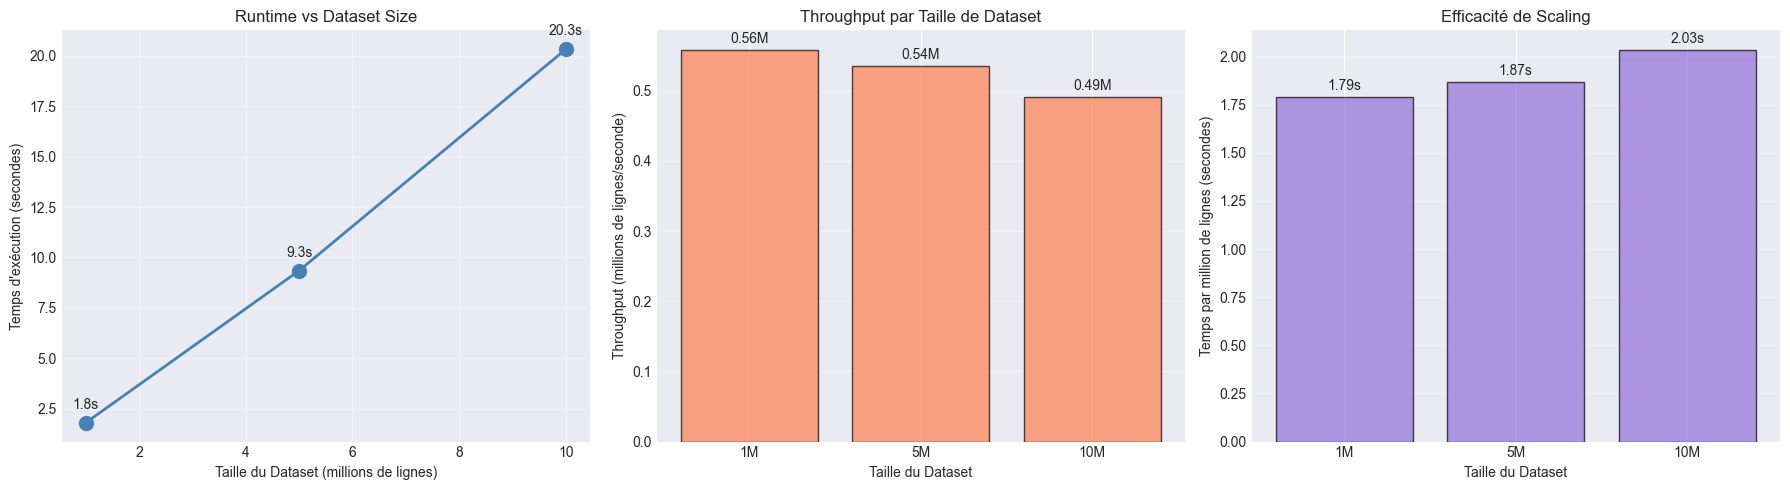

In [ ]:
results_df = pl.DataFrame(results)

results_pd = results_df.to_pandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(results_pd['rows'] / 1_000_000, results_pd['execution_time'], 
                marker='o', linewidth=2, markersize=10, color='steelblue')
axes[0].set_xlabel('Taille du Dataset (millions de lignes)')
axes[0].set_ylabel('Temps d\'exécution (secondes)')
axes[0].set_title('Runtime vs Dataset Size')
axes[0].grid(True, alpha=0.3)
for i, (rows, time_val) in enumerate(zip(results_pd['rows'] / 1_000_000, results_pd['execution_time'])):
    axes[0].annotate(f'{time_val:.1f}s', (rows, time_val), 
                        textcoords="offset points", xytext=(0,10), ha='center')

axes[1].bar(range(len(results_pd)), results_pd['rows_per_second'] / 1_000_000, 
               color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(results_pd)))
axes[1].set_xticklabels([f"{int(r/1_000_000)}M" for r in results_pd['rows']])
axes[1].set_xlabel('Taille du Dataset')
axes[1].set_ylabel('Throughput (millions de lignes/seconde)')
axes[1].set_title('Throughput par Taille de Dataset')
axes[1].grid(True, alpha=0.3, axis='y')
for i, throughput in enumerate(results_pd['rows_per_second'] / 1_000_000):
    axes[1].annotate(f'{throughput:.2f}M', (i, throughput), 
                       textcoords="offset points", xytext=(0,5), ha='center')

time_per_million = results_pd['execution_time'] / (results_pd['rows'] / 1_000_000)
axes[2].bar(range(len(results_pd)), time_per_million, 
              color='mediumpurple', edgecolor='black', alpha=0.7)
axes[2].set_xticks(range(len(results_pd)))
axes[2].set_xticklabels([f"{int(r/1_000_000)}M" for r in results_pd['rows']])
axes[2].set_xlabel('Taille du Dataset')
axes[2].set_ylabel('Temps par million de lignes (secondes)')
axes[2].set_title('Efficacité de Scaling')
axes[2].grid(True, alpha=0.3, axis='y')
for i, time_per_mil in enumerate(time_per_million):
    axes[2].annotate(f'{time_per_mil:.2f}s', (i, time_per_mil), 
                       textcoords="offset points", xytext=(0,5), ha='center')

plt.tight_layout()
plt.show()
